In [236]:
%load_ext autoreload  
%autoreload 2   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import STL
from torch.utils.data import DataLoader

from dataset import TrainDataset, extract_data
from itertools import product
from model import HybridLSTMGRU
import evaluation as eval


from train import train_config

# Modèle appliqué au données sur le chômage

Dataset extrait chômage :

- Date : 1983-01 à 2024-12
- Zone : France, USA, United Kingdom, Italie
- Mesure : Taux de chomage mensuel
- Unité : Pourcentage de la population active 
- Ajustement : corrigé des variations saisonieres, et des effets de calendrier (data_ocde_corr)
- Sexe : Tout 
- Âge : 15 ans et plus 

In [ ]:
dataset = pd.read_csv("Datasets/data_ocde_cor.csv", usecols=["TIME_PERIOD",'REF_AREA', "OBS_VALUE"])

pays_avaliable = dataset["REF_AREA"].unique()
pays = "FRA"

In [ ]:
dataset_FRA = dataset[dataset["REF_AREA"] == pays]
dataset_FRA.loc[:, 'TIME_PERIOD'] = pd.to_datetime(dataset_FRA["TIME_PERIOD"])
dataset_FRA = dataset_FRA.sort_values(by='TIME_PERIOD')

plt.figure(figsize=(12, 6))
plt.plot(dataset_FRA['TIME_PERIOD'], dataset_FRA['OBS_VALUE'])
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.title('Évolution des valeurs dans le temps')
plt.xticks(rotation=45)

# Formatage auto de l'axe x
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(40))  # max 10 dates visibles
plt.tight_layout()
plt.show()

## On trouve la meilleure combinaison d'hyper-paramètres

In [ ]:
# Paramètres fixes
pays = "ITA"
type = 'chomage'
ville = None
saison = None

# Paramètres testés
lr_list = [0.01, 0.001, 0.0001]
batch_list = [16, 32, 64]
seq_len_list = [3,6,9,12,15,18,21,24]

best_results_all = []

for lr, seq_len, batch_size in product(lr_list, seq_len_list, batch_list):
        print(f"Combinaison testée: lr={lr}, seq_len={seq_len}, batch_size={batch_size}")
        
        config = {"epochs": 1500,
                "batch_size": batch_size,
                "lr":lr,
                "seq_len": seq_len,
                "shift": 1,
                "scaler": "MinMaxScaler",
                "prop": [0.7, 0.15, 0.15],
                "type": type,
                "pays": pays,
                "ville": ville,
                "saison": None,
                "device": "cuda" if torch.cuda.is_available() else "cpu",
                "seed": 42,
        }
        _, best = train_config(dataset, config)
        print(f'Meilleure RMSE de validation est de {best["val_rmse"]} pour {best["epoch"]} epochs')  
        best_results_all.append(best)
        
results_df = pd.DataFrame(best_results_all)
results_df.to_csv(f'Best_parameters/{type}_{pays}.csv', index = False)

# Modèle appliqué aux données sur la température

#### Comparer les résultats entre les modèles testés et parler du meilleur modèle

#### Meilleur modèle bien meilleur que le naif dans ce cas en raison des changements drastiques ce qui n'est pas le cas pour le chomage pas autant dépendant du mois

#### Comparer meilleur modèle température vs chômage. Est-ce le même? Est-ce qu'il performe mieux sur un type de données?

#### Potentiellement voir si le meilleur modèle change pour différents pays et si meilleures performances

#### Voir si même modèle optimal pour désaisonnalisé vs pas désaisonnalisé et quel performe mieux

#### Conclusion on peut voir que le type de données affecte les performances de ce modèle qui performe mieux sur les données températures que sur les données de chômage, puisque naif meilleur pour chômage mais pas le cas pour température. Cela peut être dû au fait que le chômage dépend plus de sa dernière valeur tandis que les températures changent plus drastiquement on peut penser par exemple au mois de décembre vs janvier peut-être. Il est donc pas bon de garder valeur de décembre comme prédiction pour janvier tandis que oui pour le chômage.

## Observation des données brutes pour la France

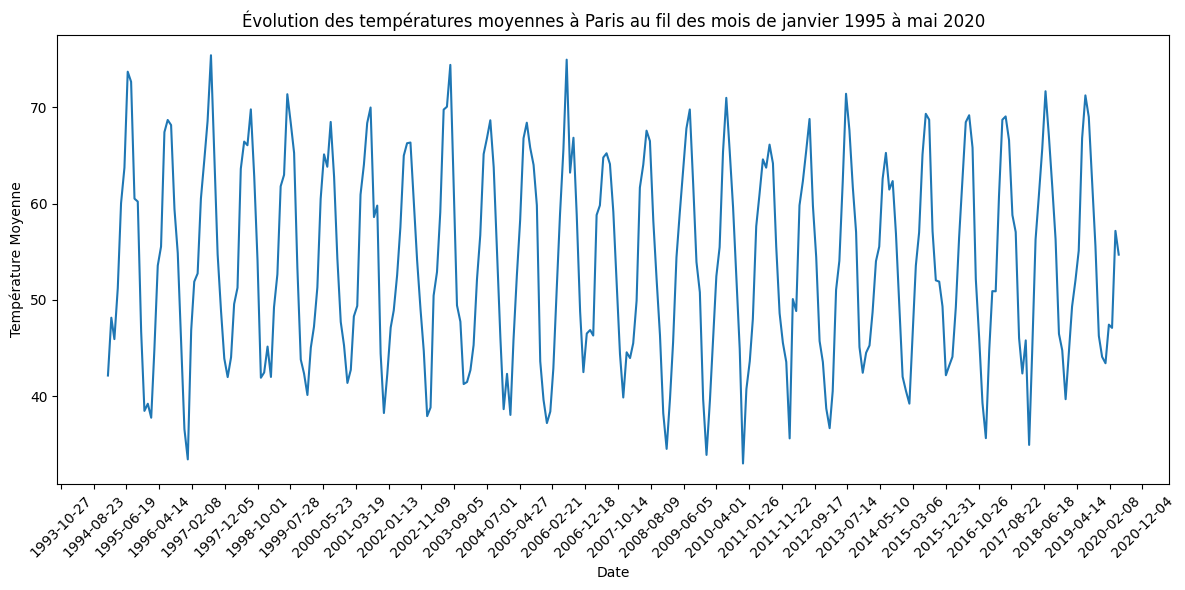

In [240]:
dataset_temp = pd.read_csv("Datasets/city_temperatures.csv", usecols=["Year", 'Month', 'Day', 'Country', 'City', 'AvgTemperature'])

# Puisqu'il y a des valeurs de -99 Farenheit pour certaines journnées, on peut assumer que celles-ci sont le résultat de valeurs manquantes
# On peut donc enlever ces valeurs de l'ensemble de données
dataset_temp = dataset_temp[dataset_temp['AvgTemperature'] > 0].reset_index(drop=True)

# Par la suite, on transforme les données pour avoir une moyenne des températures à chaque mois plutôt qu'à chaque année
dataset_temp_mensuel = dataset_temp.groupby(['Country', 'City', 'Year', 'Month'])['AvgTemperature'].mean().reset_index()

dataset_temp_mensuel['Time Period'] = dataset_temp_mensuel['Year'].astype(str) + '-' + dataset_temp_mensuel['Month'].astype(str)
dataset_temp_mensuel.loc[:, 'Time Period'] = pd.to_datetime(dataset_temp_mensuel['Time Period']).dt.date


# On fait le modèle pour les températures moyennes par mois à Paris en France
pays = 'France'
ville = 'Paris'

dataset_temp_mensuel_Paris = dataset_temp_mensuel[(dataset_temp_mensuel["City"] == ville) & (dataset_temp_mensuel["Country"] == pays)].reset_index(drop=True)
dataset_temp_mensuel_Paris = dataset_temp_mensuel_Paris.sort_values(by='Time Period')

# On visualise la série chronologique

plt.figure(figsize=(12, 6))
plt.plot(dataset_temp_mensuel_Paris['Time Period'], dataset_temp_mensuel_Paris['AvgTemperature'])
plt.xlabel('Date')
plt.ylabel('Température Moyenne')
plt.title('Évolution des températures moyennes à Paris au fil des mois de janvier 1995 à mai 2020')
plt.xticks(rotation=45)

# Formatage auto de l'axe x
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(40))  # max 10 dates visibles
plt.tight_layout()
plt.show()

## Observation données désaisonnalisées pour la France

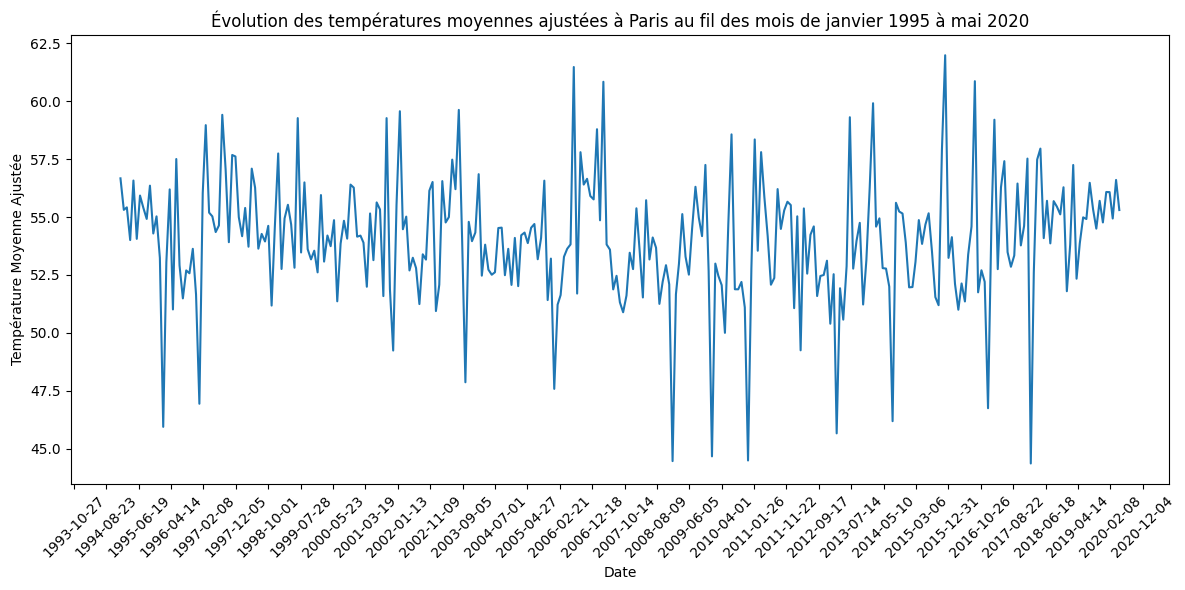

In [241]:
# Comme les données du chômage étaient désaisonnalisées, on effectue le même traitement pour ces données qui ont clairement une saisonnalité
# sur les 12 mois de l'année

stl = STL(dataset_temp_mensuel_Paris['AvgTemperature'], period = 12, robust = True)
res = stl.fit()

dataset_temp_mensuel_Paris['Saisonnalité'] = res.seasonal
dataset_temp_mensuel_Paris['AvgTemperature Adjusted'] = dataset_temp_mensuel_Paris['AvgTemperature'] - dataset_temp_mensuel_Paris['Saisonnalité']

# res.plot()
# plt.show()

# On visualise la série chronologique désaisonnalisée

plt.figure(figsize=(12, 6))
plt.plot(dataset_temp_mensuel_Paris['Time Period'], dataset_temp_mensuel_Paris['AvgTemperature Adjusted'])
plt.xlabel('Date')
plt.ylabel('Température Moyenne Ajustée')
plt.title('Évolution des températures moyennes ajustées à Paris au fil des mois de janvier 1995 à mai 2020')
plt.xticks(rotation=45)

# Formatage auto de l'axe x
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(40))  # max 10 dates visibles
plt.tight_layout()
plt.show()

# On fait la recherche d'hyper-paramètres pour le modèle appliqué au données sur la température désaisonnalisées ou encore avec saisonnalité, ainsi que pour la ville de Paris en France ainsi que la ville de Rome en Italie

In [ ]:
# Paramètres fixes du modèle 
pays = 'Italy'
ville = 'Rome'
type = 'temperature'
saison = True

# Paramètres testés
lr_list = [0.01, 0.001, 0.0001]
batch_list = [16, 32, 64]
seq_len_list = [3,6,9,12,15,18,21,24]

best_results_all = []

for lr, seq_len, batch_size in product(lr_list, seq_len_list, batch_list):
        print(f"Combinaison testée: lr={lr}, seq_len={seq_len}, batch_size={batch_size}")
        
        config = {"epochs": 1500,
                "batch_size": batch_size,
                "lr":lr,
                "seq_len": seq_len,
                "shift": 1,
                "scaler": "MinMaxScaler",
                "prop": [0.7, 0.15, 0.15],
                "type": type,
                "pays": pays,
                "ville": ville,
                "saison": saison,
                "device": "cuda" if torch.cuda.is_available() else "cpu",
                "seed": 42,
        }
        _, best = train_config(dataset_temp, config)
        print(f'Meilleure RMSE de validation est de {best["val_rmse"]} pour {best["epoch"]} epochs')  
        best_results_all.append(best)
        
results_df = pd.DataFrame(best_results_all)
results_df.to_csv(f'Best_parameters/{type}_{pays}_{ville}_{"with_season" if saison else "without_season"}.csv', index = False)

## On trouve la meilleure combinaison d'hyper-paramètres

In [247]:
with open("Best_parameters/temperature_France_Paris_with_season.csv", "r") as f:
    results_df = pd.read_csv(f)

best_row = results_df.loc[results_df['val_rmse'].idxmin()]
best_row

lr               0.000100
batch_size      16.000000
seq_len         21.000000
epoch         1251.000000
val_rmse         2.853443
val_mae          2.205158
val_mape         0.043785
train_rmse       2.872457
train_mae        2.243145
train_mape       0.044746
Name: 66, dtype: float64

## On évalue les performances du meilleur modèle trouvé

Test - RMSE: 2.6882,  MAE: 1.9386, MAPE: 3.6011
Naive - RMSE: 3.9073,  MAE: 2.7542, MAPE: 5.1878


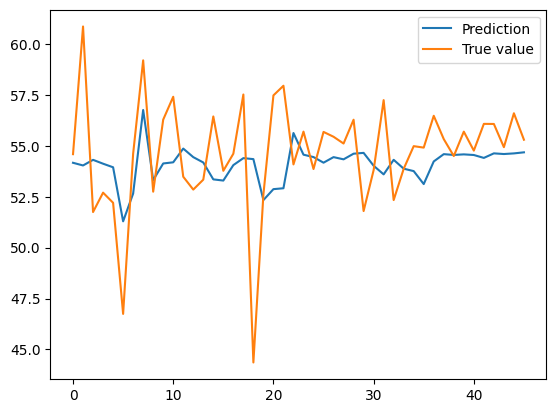

In [248]:
# On réentraine donc le modèle avec le même seed (42), puis on obtient le graphique des prédictions et des valeurs réelles
# On compare également les performances du modèle contre les performances d'un modèle naif

# Paramètres fixes du modèle 
pays = 'France'
ville = 'Paris'
type = 'temperature'
saison = False

# Paramètres optimaux
EPOCHS_opt = 350
lr_opt = 0.01
seq_len_opt = 3
batch_size_opt = 64

config = {"epochs": EPOCHS_opt,
                "batch_size": batch_size_opt,
                "lr":lr_opt,
                "seq_len": seq_len_opt,
                "shift": 1,
                "scaler": "MinMaxScaler",
                "prop": [0.7, 0.15, 0.15],
                "type": type,
                "pays": pays,
                "ville": ville,
                "saison": saison,
                "device": "cuda" if torch.cuda.is_available() else "cpu",
                "seed": 42,
        }
model_temp, best = train_config(dataset_temp, config)


if config["scaler"] == "MinMaxScaler":
        scaler = MinMaxScaler()
else:
        scaler = None
        
train_data, val_data, test_data = extract_data(
        dataset_temp,
        config["pays"],
        config["prop"],
        config["type"],
        saison=config["saison"],
        ville=config["ville"],
        scaler=scaler,
    )
# On évalue le modèle sur les données test
test_rmse_temp, test_mae_temp, test_mape_temp = eval.evaluate(model_temp, test_data, val_data, seq_len_opt, scaler)
naive_rmse_temp, naive_mae_temp, naive_mape_temp = eval.evaluate_naive(test_data, val_data, seq_len_opt, scaler)

print(f"Test - RMSE: {test_rmse_temp:.4f},  MAE: {test_mae_temp:.4f}, MAPE: {test_mape_temp:.4f}")
print(f"Naive - RMSE: {naive_rmse_temp:.4f},  MAE: {naive_mae_temp:.4f}, MAPE: {naive_mape_temp:.4f}")

eval.plot_prediction(model_temp, test_data, val_data, seq_len_opt, scaler)